<a href="https://colab.research.google.com/github/michalis0/Business-Intelligence-and-Analytics/blob/master/labs/11 - Classification 2/Walkthrough/walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> WALKTHROUGH</h1>

<div>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Logo_Universit%C3%A9_de_Lausanne.svg/2000px-Logo_Universit%C3%A9_de_Lausanne.svg.png" style="padding-right:10px;width:240px;float:left"/></td>
<h2 style="white-space: nowrap">Business Intelligence and Analytics</h2></td>
<hr style="clear:both">
<p style="font-size:0.85em; margin:2px; text-align:justify">

</div>

# Classification 2: K-Nearest Neighbours and Decision Trees

For classification we can use different algorithms, for example:
- Logisitic regression (seen last week)
- K-Nearest Neighbours
- Decision Tree
- Random Forest
- Gradient Descent
- etc...

This week we will cover **K-Nearest Neighbours** and **Decision Trees**.




For the walkthrough we will use a dataset on *fruits caracteristics* and show two new classification algorithms : __K-Nearest Neighbours__ and __Decision Trees__. Independent of which algorithm we use, we need to:
- Load our dataset
- Define our dependent and independent variables
- Split our dataset into train and test subsets
- Normalize our dataset
- Create the model (regression, KNN, decision tree, ...)
- Train our model
- Check the accuracy

In [ ]:
#Load dataset
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

url = 'https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/master/data/fruits_2025.csv'
fruits = pd.read_csv(url,sep=";")
fruits.head()

fruit_label fruit_name fruit_subtype  mass  width  height  color_score
0            1      apple  granny_smith   192    8.4     7.3         0.55
1            1      apple  granny_smith   190    8.3     7.2         0.56
2            1      apple  granny_smith   194    8.5     7.4         0.54
3            1      apple  granny_smith   180    8.0     6.8         0.59
4            1      apple  granny_smith   182    8.1     6.9         0.58

Here, we want to predict the class (`fruit label`) using other features.



In [ ]:
#Define features and target variable
X = fruits[['mass', 'width', 'height', 'color_score']]
y = fruits['fruit_label']

In [ ]:
X.shape

(111, 4)

Let's see the different classes:

In [ ]:
print(fruits['fruit_name'].unique())

['apple' 'orange']


In [ ]:
print(fruits.fruit_label.unique())

[1 2]


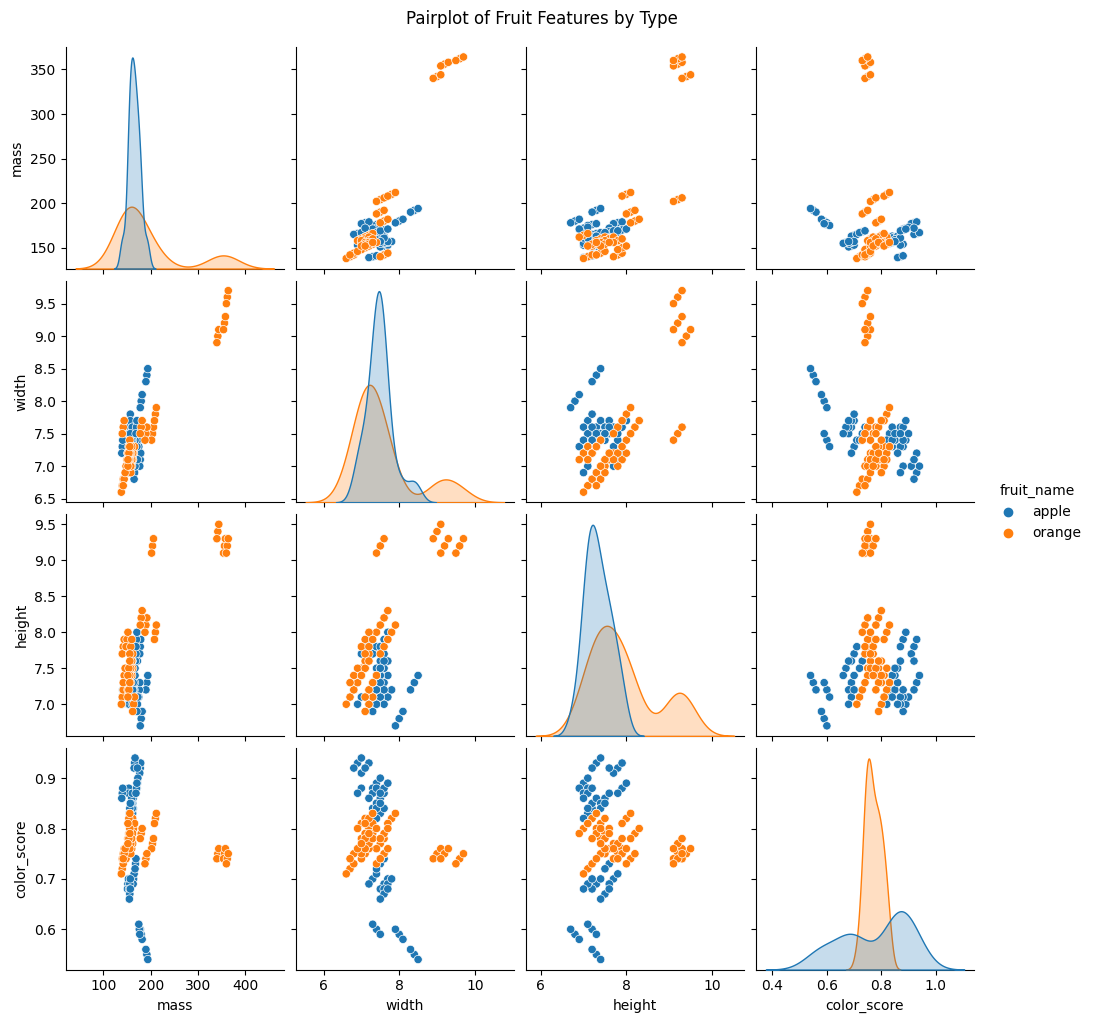

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.pairplot(fruits, hue='fruit_name', vars=['mass', 'width', 'height', 'color_score'])
plt.suptitle('Pairplot of Fruit Features by Type', y=1.02)
plt.show()

As we can see here we have two classes. This means that whenever we make predictions, a new observation (fruit) will be classified either as an apple (1) or as an orange (2).

### 1. Split into Train and Test Set

The data is split randomly into train and test subsets. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We use the test set in order to test our prediction on this subset. By default, the `train_test_split` function applies a ratio of 75%/25% to split the dataset (if nothing is given).


In [ ]:
#Split data set into a train and a test data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Let's have a quick look at our features contained in `X_train`.

In [ ]:
X_train.describe()

mass      width     height  color_score
count   83.000000  83.000000  83.000000    83.000000
mean   181.530120   7.540964   7.651807     0.772410
std     58.870121   0.668277   0.653016     0.085762
min    138.000000   6.600000   6.700000     0.540000
25%    154.000000   7.150000   7.200000     0.735000
50%    162.000000   7.400000   7.500000     0.770000
75%    177.500000   7.600000   7.900000     0.830000
max    364.000000   9.700000   9.400000     0.940000

### 2. Normalization

When we have a dataset with features that have very distinct ranges (for example one feature where the age is between 0 and 99 years and another feature being the income ranging from 1'000 CHF to 200'000 CHF), we might get biaised results. We want the features to be in the same or similar ranges/units. Therefore, we **normalize** the data. It involves scaling all values for a specific feature given attribute so that they fall within a small specified range.
We can use the *StandardScaler()*, the *MinMaxScaler* () or other scalers for the normalization.
<br>

In our example we will normalize our **train AND test set** using the MinMaxScaler. This will give all features values between 0 and 1.

**IMPORTANT**: When you normalize the train set, you need to do the same modificaiton (here normalization) to the test set.

In [ ]:
#Define normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [ ]:
#Apply normalization
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Let's quickly check that our features contained in X_train have been normalized: all values are between the (0,1) range.

In [ ]:
pd.DataFrame(X_train, columns=['mass', 'width', 'height', 'color_score']).describe()

mass      width     height  color_score
count  83.000000  83.000000  83.000000    83.000000
mean    0.192611   0.303537   0.352521     0.581024
std     0.260487   0.215573   0.241858     0.214405
min     0.000000   0.000000   0.000000     0.000000
25%     0.070796   0.177419   0.185185     0.487500
50%     0.106195   0.258065   0.296296     0.575000
75%     0.174779   0.322581   0.444444     0.725000
max     1.000000   1.000000   1.000000     1.000000

### 3. K-Nearest Neighbor

The KNN algorithm classifies new examples considering the most represented class among the K nearest neighbors in the hyperspace. This means that if k = 1, the object is simply assigned to the class of the single nearest neighbor. If k = 5, then the classification of the object will be based on a majority vote of the 5 nearest datapoints. It is simple to implement, robust to noisy training set, and effective if the training set is large. Nevertheless, we need to determine the value of K and the computation cost is high as it needs to compute the distance of each instance to all the training samples. <br>

As seen before, we will first need to create our model. We will build the model from the **training set**. We have already split our dataset into **test** and **trainig sets**.

Here we need to specify **how many neighbors** are to be considered in the classification when creating the model.

In [ ]:
#Create model with K=11
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=11)

In [ ]:
#Fit model
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [ ]:
#Use model on test and check accuracy

print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(model.score(X_train, y_train)))

Accuracy of KNN classifier on test set: 1.00
Accuracy of KNN classifier on training set: 0.99


We chose k = 11 arbitrarily, maybe we can have a better accuracy with another number. Similarly we could change other parameters. Let's try with a different **weight** which gives less importance to far away points and to **p** to change the way we compute distance between 2 points [See here for information on p-norm](https://en.wikipedia.org/wiki/Minkowski_distance). Let's try for different values.

Below we use a number of different prameters:
- `n_neighbors`=number of neighboring observations to use
- `p`= determines the distance/similarity metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.
- `weights`= determines how to weigh the neighboring observations.
  - When set to `uniform` : uniform weights. All points in each neighborhood are weighted equally.
  - When set to `distance` : weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

For a full list of available parameters you can check the [documentation file](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [ ]:
n_neighbors = [2,3,4,5]
p_values = [1,2,3]
weights = ['uniform', 'distance']
for n in n_neighbors:
    for p in p_values:
        for w in weights:
            model = KNeighborsClassifier(n_neighbors=n, p=p, weights=w)
            model.fit(X_train, y_train)
            print("accuracy for k = " + str(n) + ", p = " + str(p) + ", weight = " + w + " : " + str(model.score(X_test, y_test)))

accuracy for k = 2, p = 1, weight = uniform : 0.8928571428571429
accuracy for k = 2, p = 1, weight = distance : 0.9285714285714286
accuracy for k = 2, p = 2, weight = uniform : 0.8928571428571429
accuracy for k = 2, p = 2, weight = distance : 0.9285714285714286
accuracy for k = 2, p = 3, weight = uniform : 0.8928571428571429
accuracy for k = 2, p = 3, weight = distance : 0.8928571428571429
accuracy for k = 3, p = 1, weight = uniform : 0.9642857142857143
accuracy for k = 3, p = 1, weight = distance : 0.9642857142857143
accuracy for k = 3, p = 2, weight = uniform : 0.9642857142857143
accuracy for k = 3, p = 2, weight = distance : 0.9642857142857143
accuracy for k = 3, p = 3, weight = uniform : 0.9642857142857143
accuracy for k = 3, p = 3, weight = distance : 0.9642857142857143
accuracy for k = 4, p = 1, weight = uniform : 0.9285714285714286
accuracy for k = 4, p = 1, weight = distance : 0.9285714285714286
accuracy for k = 4, p = 2, weight = uniform : 0.8571428571428571
accuracy for k = 4

In [ ]:
def plot_knn_decision_boundaries(X, y, weights='uniform', metric='minkowski', n_neighbors_list=[1, 3, 5, 11]):
    # We'll use only two features for visualization
    X_subset = X[:, [1, 2]]  # Using width and height

    feature_names = ['width', 'height']

    # Set up the figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    # Define colors for plotting
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#FFFF00'])

    for i, n_neighbors in enumerate(n_neighbors_list):
        # Create and fit the KNN classifier
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
        knn.fit(X_subset, y)

        # Plot decision boundary
        disp = DecisionBoundaryDisplay.from_estimator(
            knn,
            X_subset,
            cmap=cmap_light,
            alpha=0.5,
            ax=axes[i],
            response_method="predict",
        )

        # Plot training points
        scatter = axes[i].scatter(X_subset[:, 0], X_subset[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=50)

        # Add legend
        legend = axes[i].legend(*scatter.legend_elements(), title="Classes")
        axes[i].add_artist(legend)

        axes[i].set_title(f'KNN (k={n_neighbors})')
        axes[i].set_xlabel(feature_names[0])
        axes[i].set_ylabel(feature_names[1])

    plt.tight_layout()
    plt.suptitle('KNN Decision Boundaries with Different k Values', y=1.05, fontsize=16)
    plt.show()

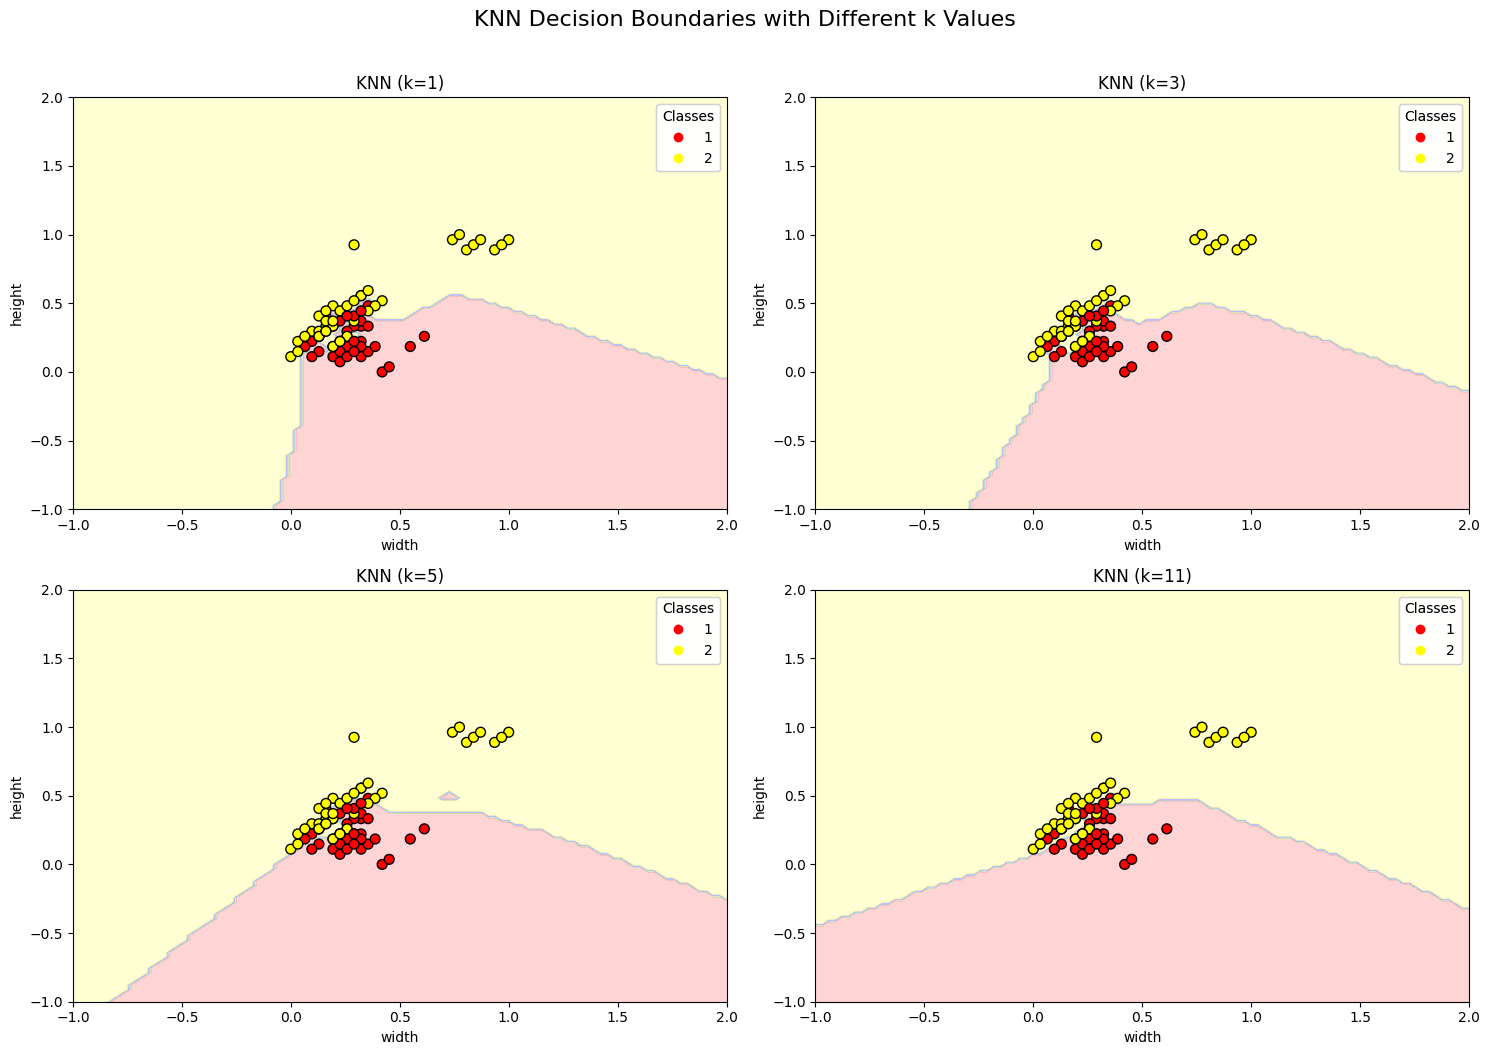

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay
plot_knn_decision_boundaries(X_train, y_train)

#### 4. Tuning hyperparameters with cross-validation

We now want to find which hyperparameters of the [KNN class](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) are the optimal ones. For this we use [Grid Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
# Grid Search - hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define parameters to test
grid = {'n_neighbors':np.arange(1,10),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }

# Define and fit model
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=10)
knn_cv.fit(X_train, y_train)

# Print results
print("Hyperparameters:", knn_cv.best_params_)
print("Train Score:", round(knn_cv.best_score_, 4))
print("Test Score:", round(knn_cv.score(X_test, y_test), 4))

Hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Train Score: 0.9875
Test Score: 0.9643


### 5. Decision Tree
A decision tree classifier relies on a decision tree to predict the class of a new datapoint. In fact, it produces a sequence of rules that can be used to classify the data. It is a great algorithm as it is easy to understand and visualize. Furthermore, it can handle numerical and categorical data.

 **Warning:** It is possible that decision trees build models that are too complex or that cannot generalize well (overfitting). It can also be unstable, as small variations in the data set might cause the generation of a completely different tree. <br>

Before building it we need to specify the maximum depth of our tree, which represents the amount of nodes we allow the tree to generate.

In [ ]:
#create, fit and test model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth = 5)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.8928571428571429


We achieve perfection on the test set, but our model may be overly complicated. Let's see if we can reduce max depth without losing accuracy.
Let's randomly try some numbers.

In [ ]:
model = DecisionTreeClassifier(max_depth = 1)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.75


In [ ]:
#function to find the tree with the lowest depth (less complicated model) keeping an accuracy of 1
depth = 5
model = DecisionTreeClassifier(max_depth = depth)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
while accuracy == 1:
    depth -= 1
    model = DecisionTreeClassifier(max_depth = depth)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
print(depth+1)

6


/tmp/ipykernel_27150/2761509241.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,


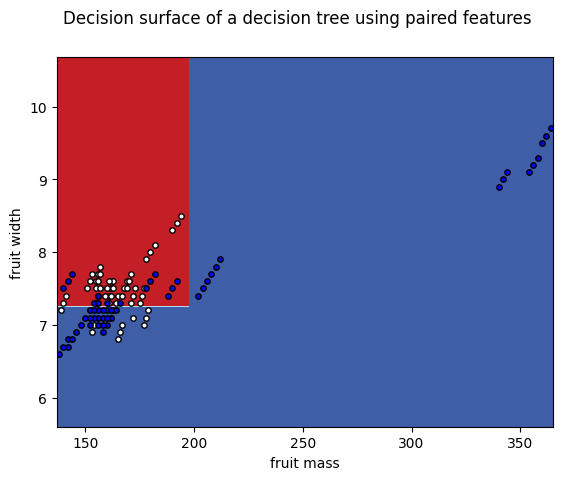

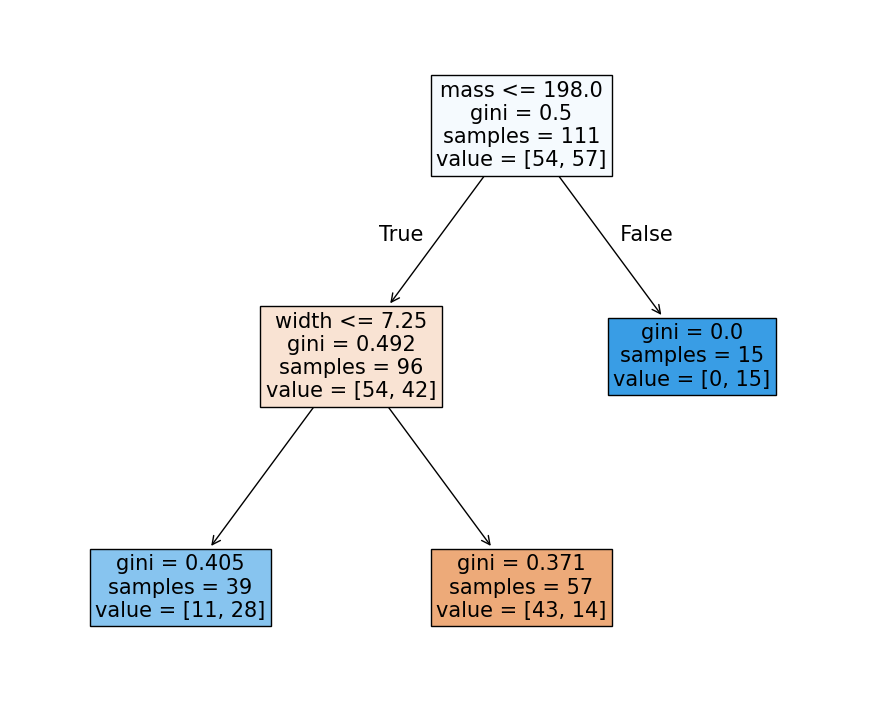

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree

plot_colors = "wb"
plot_step = 0.02


X = X[['mass', 'width']].values

clf = DecisionTreeClassifier(max_depth = 2).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('fruit mass')
plt.ylabel('fruit width')

# Plot the training points
for i, color in zip(range(2), plot_colors):
    idx = np.where(y == i+1)
    plt.scatter(X[idx, 0], X[idx, 1], c=color,
                cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.axis("tight")

plt.figure(figsize=(11,9))
clf = DecisionTreeClassifier(max_depth = 2).fit(X, y)
plot_tree(clf, filled=True, feature_names=('mass', 'width'), fontsize=15)
plt.show()

A few words about our decision tree:  
It starts with the root in which we have 38 samples (our data points) of which 19 belong to class 1 and 19 belong to class 2.
Each node represents a condition on which the tree splits into branches. The end of a branch that no longer splits is a leaf.
The gini coefficient is our measure of purity for each node. In our dataset we start with 0.5 (corresponds to the 50-50 distribution of classes in the root) and then gradually go down to 0 (maximum purity).